In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 读取CSV文件
df = pd.read_csv('merged_metric_results.csv')

# 显示前几行数据以确认读取正确
# print(df.head())

# 检查 'value' 列的数据类型
# print(df['value'].dtype)

# 将 'value' 列转换为数值类型
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# 定义要统计的 metric_names
metrics_to_sum = [
    'smsp__sass_thread_inst_executed_op_ffma_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_fadd_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_fmul_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_fp32_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_hfma_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_hadd_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_hmul_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_fp16_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_dfma_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_dadd_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_dmul_pred_on.sum',
    'smsp__sass_thread_inst_executed_op_fp64_pred_on.sum'
]

# 计算每个 metric_name 的 value 列的总和
results = {}
for metric in metrics_to_sum:
    filtered_df = df[df['metric_name'] == metric]
    total_sum = filtered_df['value'].sum()
    results[metric] = total_sum

# 打印每个 metric_name 的 value 列的总和
for metric, total_sum in results.items():
    print(f'Total sum of values for metric_name "{metric}": {total_sum}')

# 计算复合指标
composite_metric_value = (
    results.get('smsp__sass_thread_inst_executed_op_ffma_pred_on.sum', 0) * 2 +
    results.get('smsp__sass_thread_inst_executed_op_fadd_pred_on.sum', 0) +
    results.get('smsp__sass_thread_inst_executed_op_fmul_pred_on.sum', 0)
)

# 打印复合指标的结果
print(f'Composite metric (2 * ffma + fadd + fmul): {composite_metric_value}')



Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_ffma_pred_on.sum": 1120473448.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_fadd_pred_on.sum": 156075648.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_fmul_pred_on.sum": 76583552.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_fp32_pred_on.sum": 1503918600.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_hfma_pred_on.sum": 0.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_hadd_pred_on.sum": 0.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_hmul_pred_on.sum": 0.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_fp16_pred_on.sum": 455933952.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_dfma_pred_on.sum": 0.0
Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_dadd_pred_on.sum": 0.0
Total sum

Total sum of values for metric_name "smsp__sass_thread_inst_executed_op_fp16_pred_on.sum": 455933952.0
以上结果分析可以看到，fp16是有数值的，说明部分kernel执行了fp16的运算，当然这都是在软件层面。
现在找出这些kernel

In [2]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('merged_metric_results.csv')

# 显示前几行数据以确认读取正确
# print(df.head())

# 检查 'value' 列的数据类型
# print(df['value'].dtype)

# 将 'value' 列转换为数值类型
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# 定义要筛选的 metric_name
metric_name = 'smsp__sass_thread_inst_executed_op_fp16_pred_on.sum'

# 筛选出 metric_name 为指定值且 value 不为 0 的行
filtered_df = df[(df['metric_name'] == metric_name) & (df['value'] != 0)]

# 打印筛选后的数据
print(filtered_df)

# 保存筛选后的数据到新的 CSV 文件
output_file = 'filtered_fp16_metric.csv'
filtered_df.to_csv(output_file, index=False)

print(f"Filtered data saved to {output_file}")


      session_id  range_id  launchId  \
195            2         5        15   
312            3         2        22   
430            4         0        30   
437            4         7        37   
554            5         4        44   
672            6         2        52   
790            7         0        60   
798            7         8        68   
917            8         7        77   
1035           9         5        85   
1153          10         3        93   

                                                 kernel  \
195   sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_...   
312   sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_...   
430   sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_...   
437   sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_...   
554   sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_...   
672   _ZN17cutlass__5x_cudnn6KernelI66cutlass_tensor...   
790   _ZN17cutlass__5x_cudnn6KernelI66cutlass_tensor...   
798   _ZN17cutlass__5x_cudnn6KernelI66cutlass_t

In [3]:
import json

# 创建字典描述简化前后的 kernel name 对应关系
kernel_name_mapping = {
    "_ZN14cask__5x_cudnn20computeOffsetsKernelILb0ELb0EEEvNS_20ComputeOffsetsParamsE": "computeOffsetsKernel",
    "_5x_cudnn_ampere_scudnn_128x64_relu_medium_nn_v1": "ampere_scudnn_128x64_relu",
    "_ZN2at6native18elementwise_kernelILi128ELi2EZNS0_22gpu_kernel_impl_nocastINS0_15CUDAFunctor_addIfEEEEvRNS_18TensorIteratorBaseERKT_EUliE_EEviT1_": "elementwise_kernel_gpu_kernel_impl_nocast",
    "_ZN2at6native29vectorized_elementwise_kernelILi4ENS0_21CUDAFunctorOnSelf_addIlEENS_6detail5ArrayIPcLi2EEEEEviT0_T1_": "vectorized_elementwise_kernel",
    "_ZN5cudnn25bn_fw_tr_1C11_kernel_NCHWIffiLi512ELb1ELi1ELb1EEEv17cudnnTensorStructPKT_S1_PS2_PKT0_S8_S6_S6_PS6_S9_S9_S9_S6_S6_": "bn_fw_tr_1C11_kernel_NCHW_cudnnTensorStruct",
    "_ZN2at6native29vectorized_elementwise_kernelILi4EZZZNS0_49_GLOBAL__N__d2ba64fb_16_TensorCompare_cu_71e06f4e19launch_clamp_scalarERNS_18TensorIteratorBaseEN3c106ScalarES6_NS0_6detail11ClampLimitsEENKUlvE_clEvENKUlvE5_clEvEUlfE_NS_6detail5ArrayIPcLi2EEEEEviT0_T1_": "vectorized_elementwise_kernel_TensorCompare_cu_launch_clamp_scalar",
    "_ZN5cudnn8winograd27generateWinogradTilesKernelILi0EffEEvNS0_27GenerateWinogradTilesParamsIT0_T1_EE": "generateWinogradTilesKernel",
    "_5x_cudnn_ampere_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v1": "ampere_scudnn_winograd_128x128_relu",
    "_ZN2at6native52_GLOBAL__N__e57809e0_19_DilatedMaxPool2d_cu_6258b57421max_pool_forward_nchwIfEEviPKT_llliiiiiiiiiiPS3_Pl": "max_pool_forward_nchw",
    "_ZN5cudnn19engines_precompiled16nchwToNhwcKernelIfffLb0ELb1EL21cudnnKernelDataType_t2EEEvNS0_18nchw2nhwc_params_tIT1_EEPKT_PT0_": "engines_precompiled_nchwToNhwcKernel_Lb0ELb1E",
    "_ZN5cudnn24bn_fw_tr_1C11_singlereadIfLi512ELb1ELi1ELi2ELi0EEEvNS_18bn_fw_tr_1C11_argsIT_EE": "bn_fw_tr_1C11_singleread",
    "_ZN17cutlass__5x_cudnn6KernelI66cutlass_tensorop_s1688fprop_optimized_tf32_128x64_16x6_nhwc_align4EEvNT_6ParamsE": "Kernel_fprop_optimized16x6",
    "_ZN5cudnn19engines_precompiled16nhwcToNchwKernelIfffLb1ELb0EL21cudnnKernelDataType_t0EEEvNS0_18nhwc2nchw_params_tIT1_EEPKT_PT0_": "engines_precompiled_nhwcToNchwKernel_Lb1ELb0E",
    "_ZN17cutlass__5x_cudnn6KernelI66cutlass_tensorop_s1688fprop_optimized_tf32_128x64_32x3_nhwc_align4EEvNT_6ParamsE": "Kernel_fprop_optimized32x3",
    "_ZN8internal5gemvx6kernelIiiffffLb0ELb1ELb1ELb0ELi7ELb0E16cublasGemvParamsI30cublasGemvTensorStridedBatchedIKfES5_S3_IfEfEEENSt9enable_ifIXntT5_EvE4typeET11_": "gemvx6kernel",
    "_ZN2at6native43_GLOBAL__N__50f1b6c4_10_Dropout_cu_0e96ed3824fused_dropout_kernel_vecIffjLi1ELi4EbEEvNS_4cuda6detail10TensorInfoIKT_T1_EENS5_IS6_S8_EENS5_IT4_S8_EES8_T0_NS_15PhiloxCudaStateE": "fused_dropout_kernel_vec",
    "_Z17gemv2T_kernel_valIiiffffLi128ELi16ELi4ELi4ELb0ELb1E16cublasGemvParamsI30cublasGemvTensorStridedBatchedIKfES3_S1_IfEfEEvT11_T4_S7_": "gemv2T_kernel_val",
    "sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_f32_nhwckrsc_nchw_tilesize256x128x32_stage2_warpsize4x2x1_g1_tensor16x8x8_alignc4_execute_kernel__5x_cudnn": "sm86_xmma_fprop_implicit_gemm_tile256x128x32_stage2_warp4x2x1_execute_kernel",
    "sm86_xmma_fprop_implicit_gemm_tf32f32_tf32f32_f32_nhwckrsc_nchw_tilesize128x128x16_stage3_warpsize2x2x1_g1_tensor16x8x8_alignc4_execute_kernel__5x_cudnn": "sm86_xmma_fprop_implicit_gemm_tile128x128x16_stage3_warp2x2x1_execute_kernel",
    "sm86_xmma_fprop_implicit_gemm_indexed_tf32f32_tf32f32_f32_nhwckrsc_nhwc_tilesize128x64x32_stage4_warpsize2x2x1_g1_tensor16x8x8_execute_kernel__5x_cudnn": "sm86_xmma_fprop_implicit_gemm_indexed_tile128x64x32_stage4_warp2x2x1_execute_kernel"
}

# 将字典转换为 JSON 格式并写入文件
with open('kernel_name_mapping.json', 'w') as json_file:
    json.dump(kernel_name_mapping, json_file, indent=4)

print("JSON file has been created successfully.")


JSON file has been created successfully.


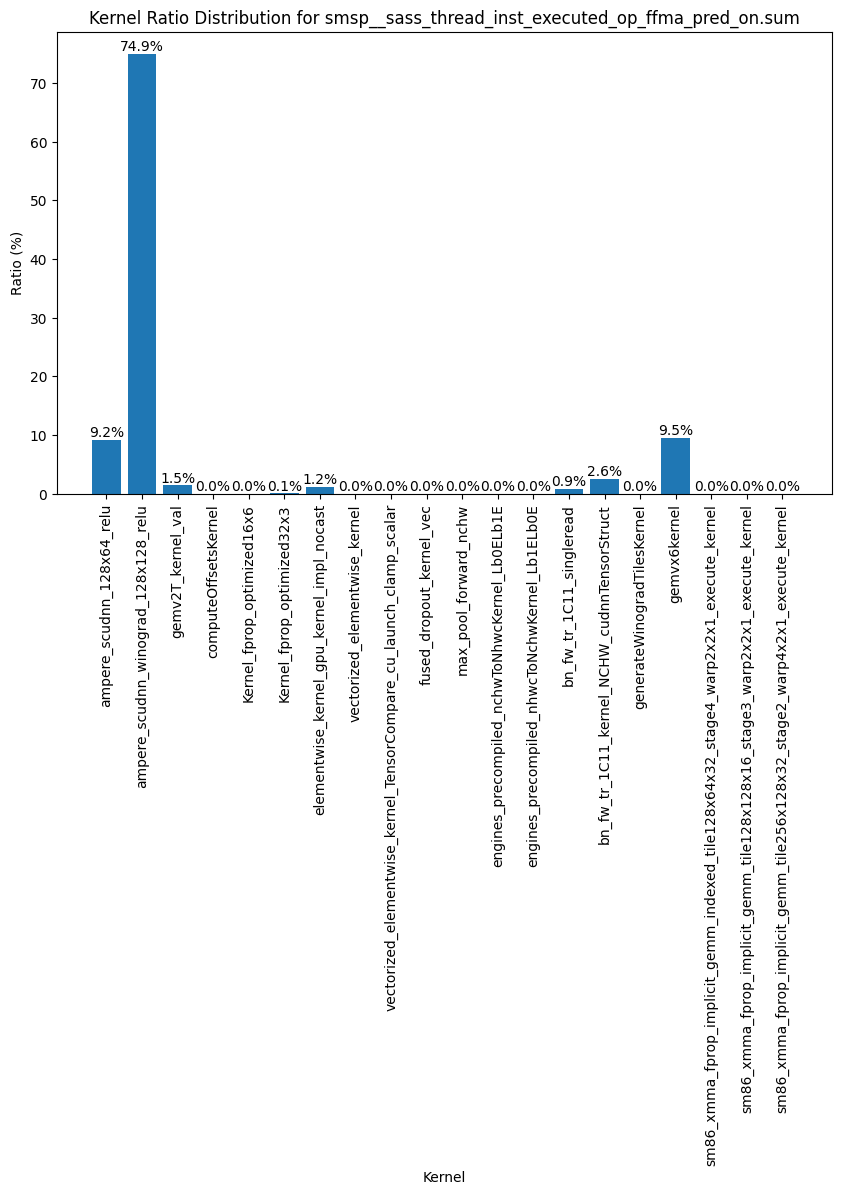

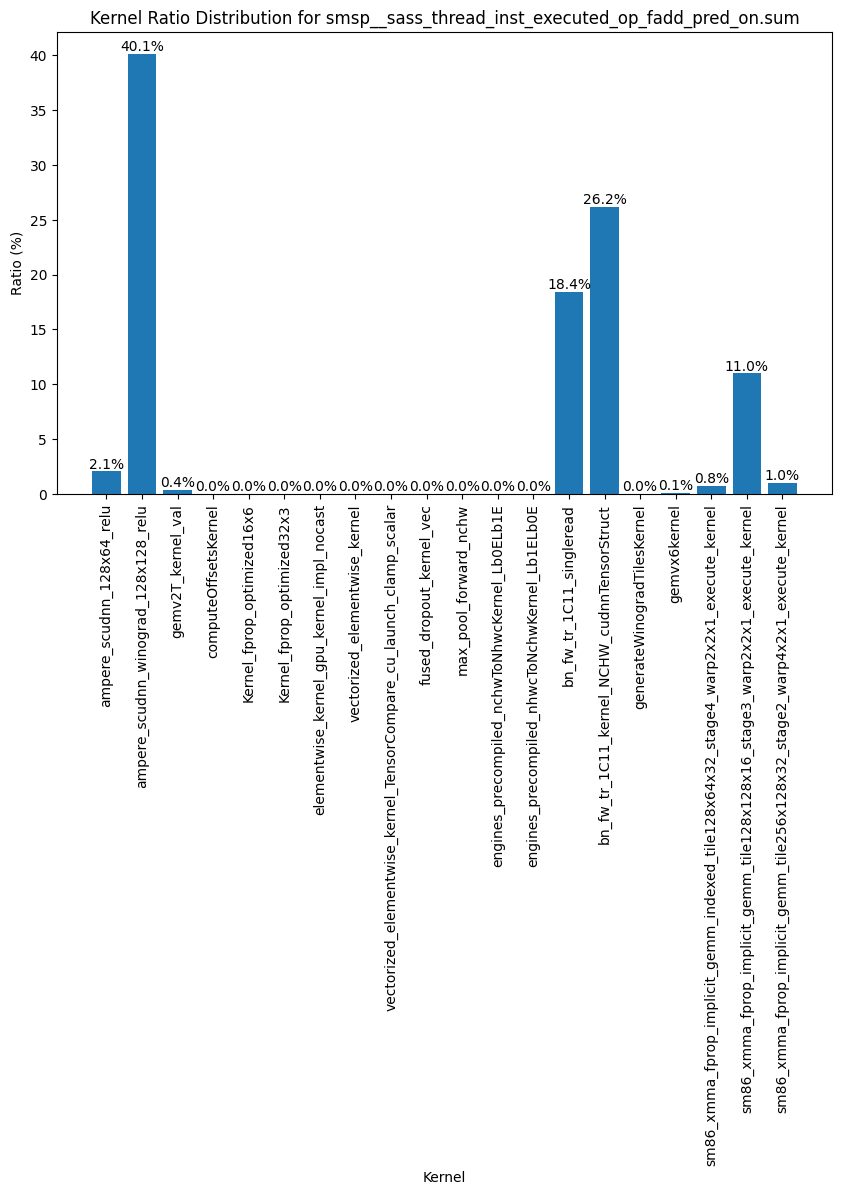

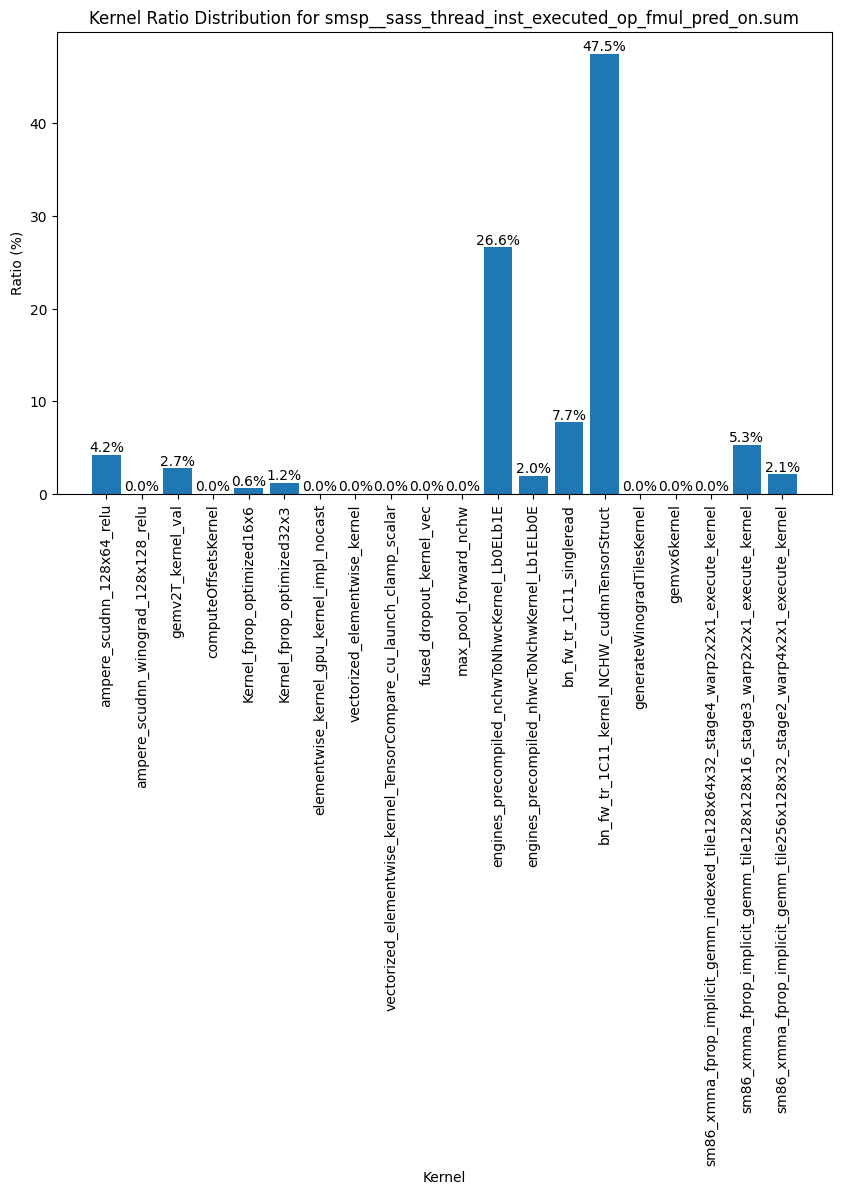

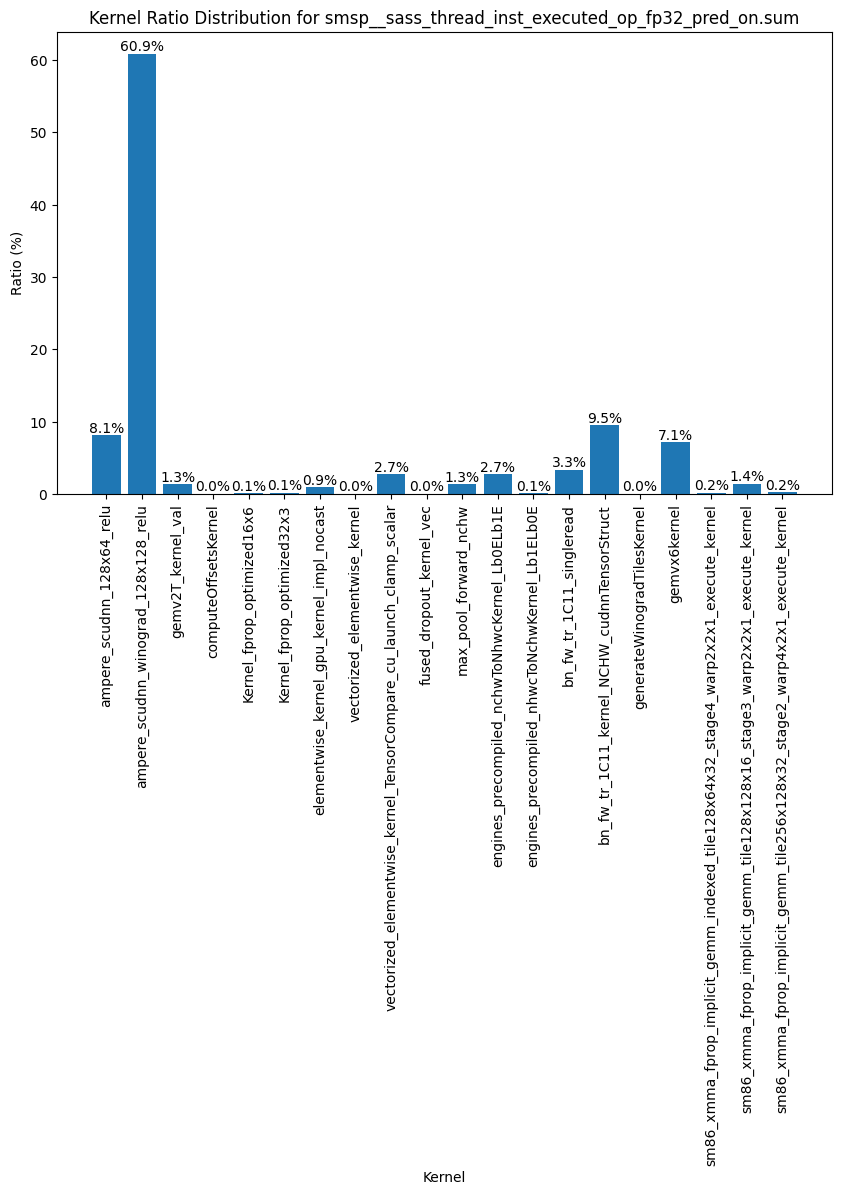

No valid data to plot for metric: smsp__sass_thread_inst_executed_op_hfma_pred_on.sum
No valid data to plot for metric: smsp__sass_thread_inst_executed_op_hadd_pred_on.sum
No valid data to plot for metric: smsp__sass_thread_inst_executed_op_hmul_pred_on.sum


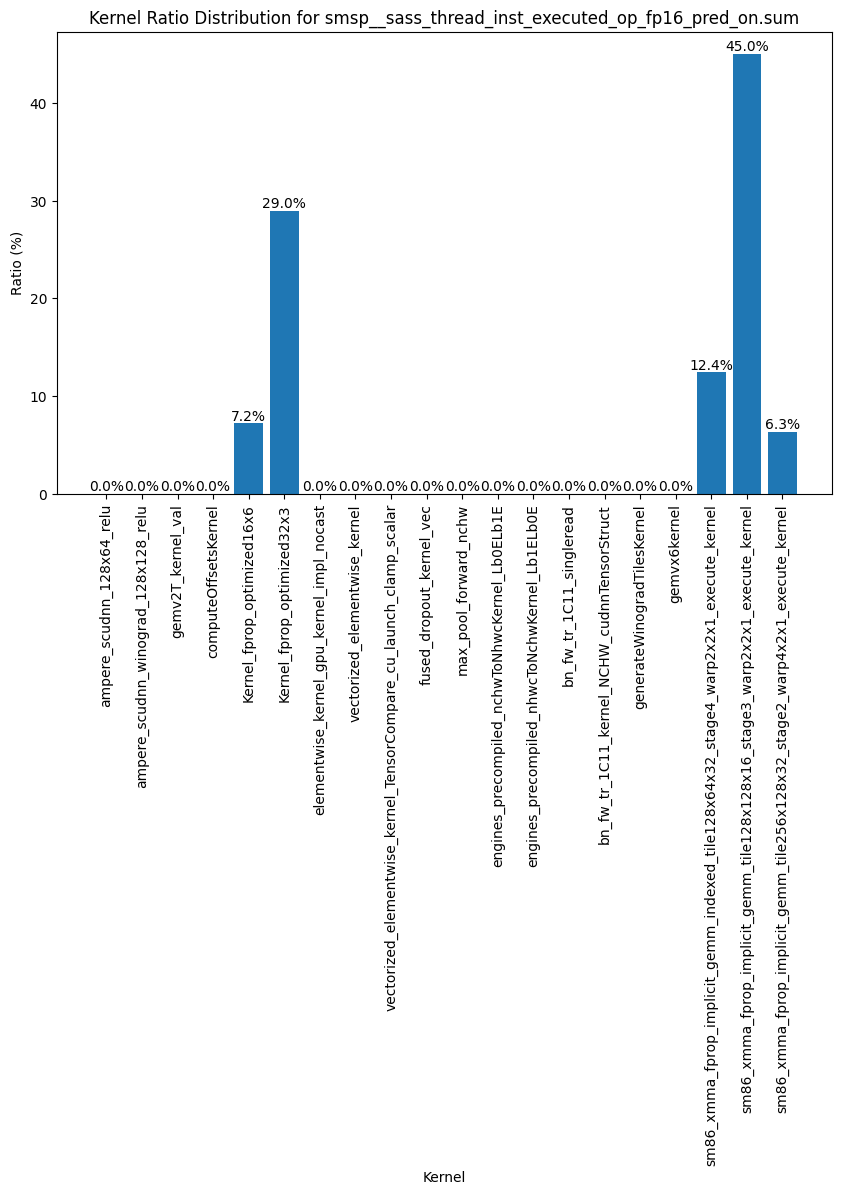

No valid data to plot for metric: smsp__sass_thread_inst_executed_op_dfma_pred_on.sum
No valid data to plot for metric: smsp__sass_thread_inst_executed_op_dadd_pred_on.sum
No valid data to plot for metric: smsp__sass_thread_inst_executed_op_dmul_pred_on.sum
No valid data to plot for metric: smsp__sass_thread_inst_executed_op_fp64_pred_on.sum


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json

# 读取 kernel_name_mapping.json 文件
with open('kernel_name_mapping.json', 'r') as json_file:
    kernel_name_mapping = json.load(json_file)

# 创建 label 列
df['label'] = df.apply(lambda row: f"{row['session_id']},{row['range_id']},{row['kernel']}", axis=1)

# 指定保存图表的文件夹
output_folder = 'charts'
os.makedirs(output_folder, exist_ok=True)  # 创建文件夹（如果不存在）

# 绘制每种 metric_name 的柱状图
for metric in metrics_to_sum:
    # 过滤当前 metric_name 的数据
    filtered_df = df[df['metric_name'] == metric]
    
    # 计算每个 kernel 的 value 总和
    kernel_sums = filtered_df.groupby('kernel')['value'].sum().reset_index()
    
    # 计算每个 kernel 的 ratio
    if results[metric] > 0:
        kernel_sums['ratio'] = kernel_sums['value'] / results[metric] * 100
    else:
        kernel_sums['ratio'] = 0.0
    
    # 提取 labels 和 ratios
    labels = kernel_sums['kernel']
    ratios = kernel_sums['ratio']
    
    # 处理 NaN 值
    valid_indices = ~ratios.isna()
    valid_labels = labels[valid_indices]
    valid_ratios = ratios[valid_indices]
    
    # 简化 kernel 名称
    simplified_labels = [kernel_name_mapping.get(label, label) for label in valid_labels]
    
    # 检查是否所有比率都为0
    if not valid_ratios.empty and valid_ratios.sum() > 0:
        plt.figure(figsize=(10, 6))
        bars = plt.bar(simplified_labels, valid_ratios)
        plt.title(f'Kernel Ratio Distribution for {metric}')
        plt.xlabel('Kernel')
        plt.ylabel('Ratio (%)')
        plt.xticks(rotation=90)
        
        # 在柱状图顶部显示实际的占比
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')
        
        # 保存柱状图到指定文件夹
        bar_chart_path = os.path.join(output_folder, f'bar_{metric}.png')
        plt.savefig(bar_chart_path)
        plt.show()
    else:
        print(f"No valid data to plot for metric: {metric}")
